In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from tslearn.svm import TimeSeriesSVR
import Dense_model as Dense
import LSTM_model as LSTM

In [2]:
TRAIN_TEST_SPLIT = 0.8

In [3]:
labels = ['PM2.5_pi', 'PM10_pi']

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


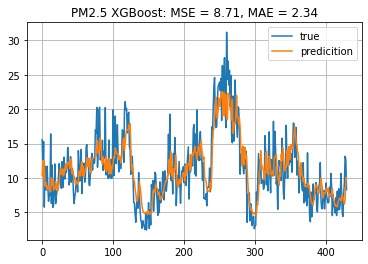

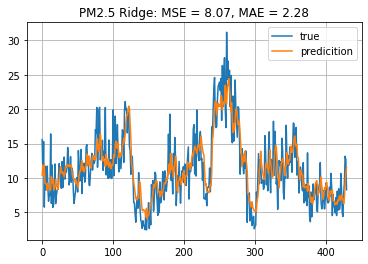

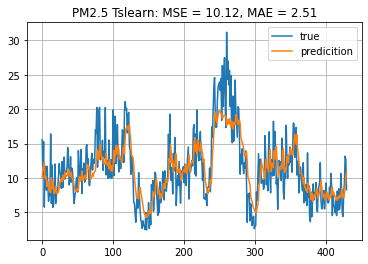

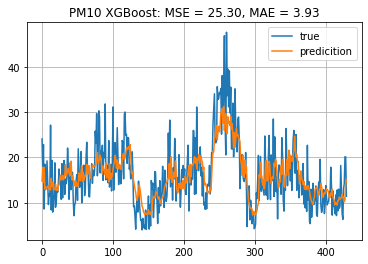

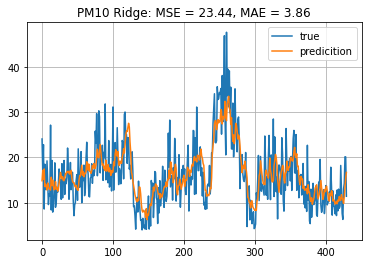

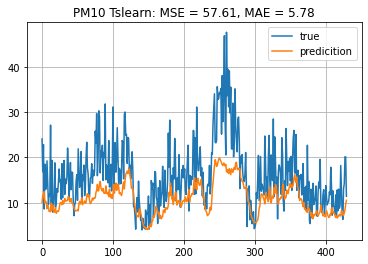

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


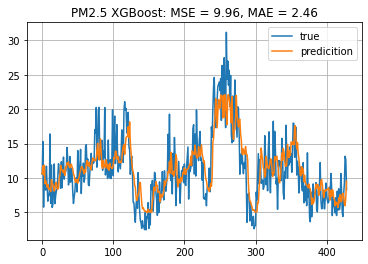

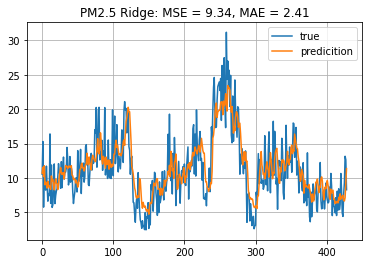

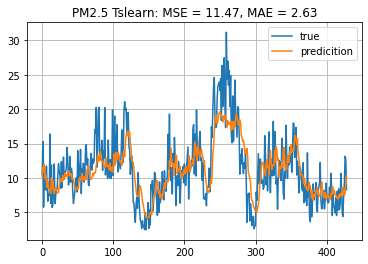

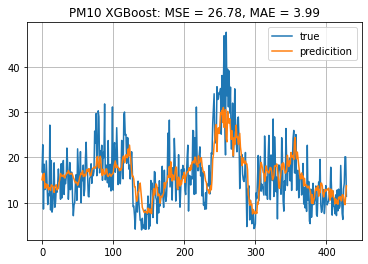

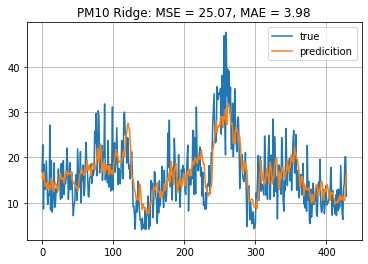

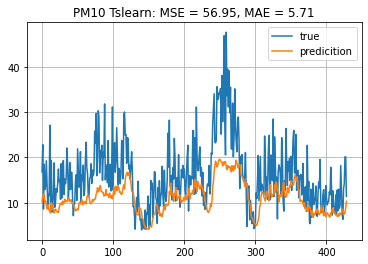

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


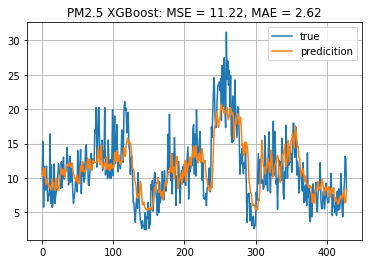

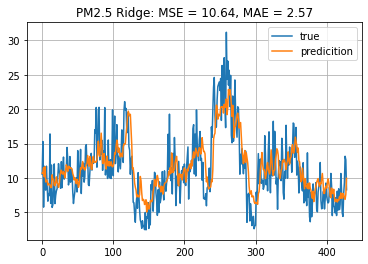

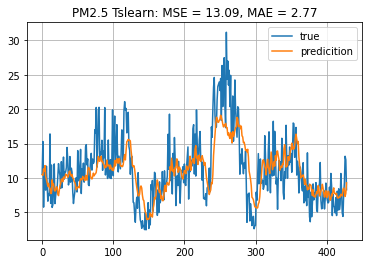

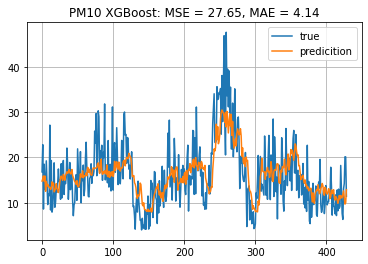

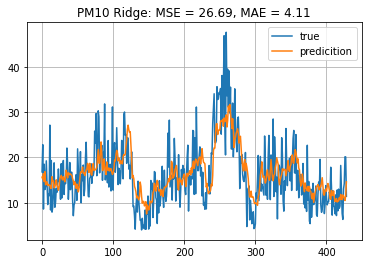

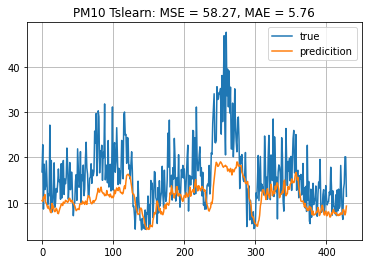

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


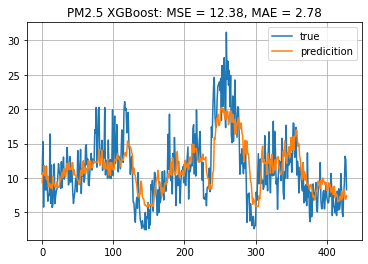

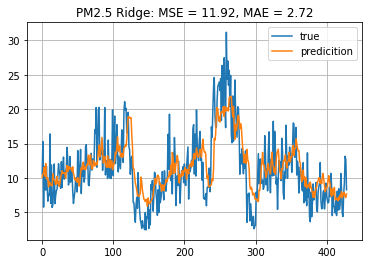

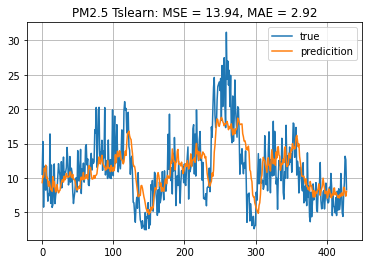

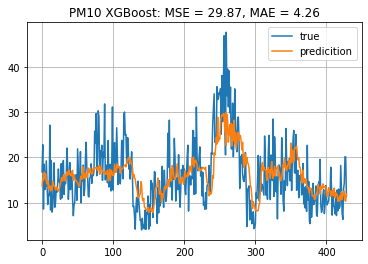

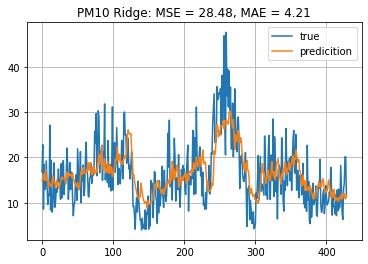

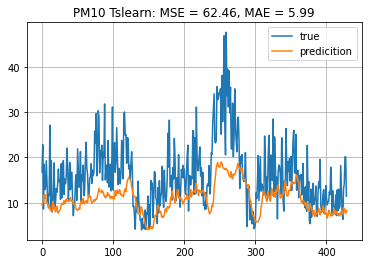

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


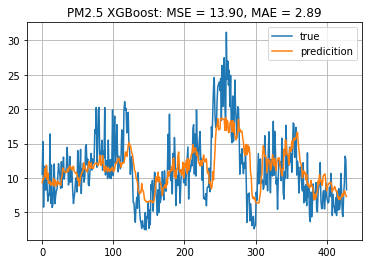

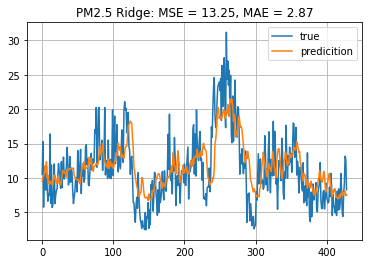

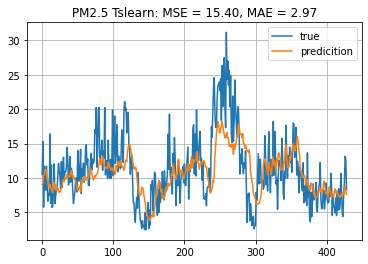

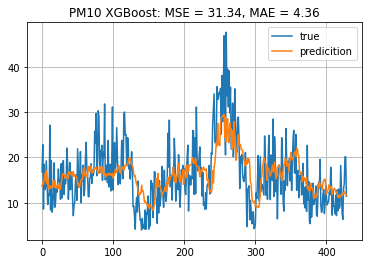

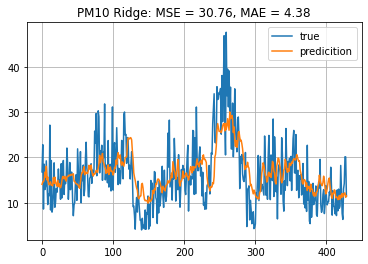

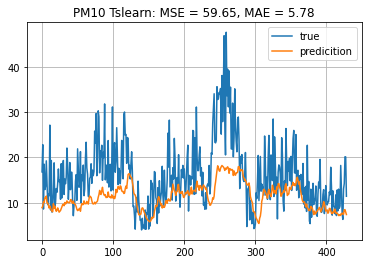

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


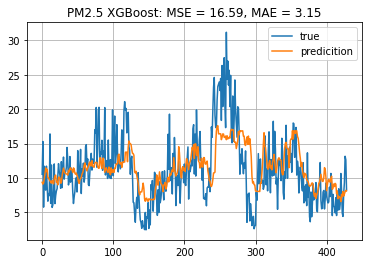

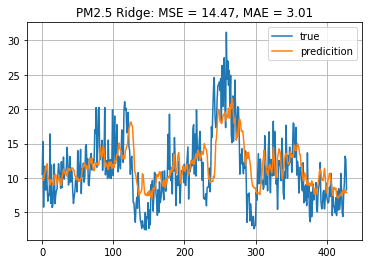

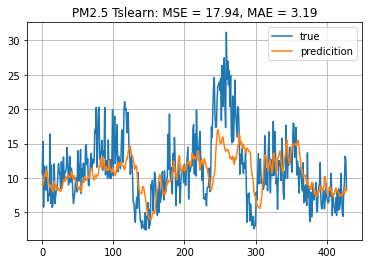

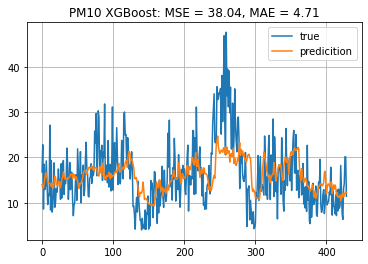

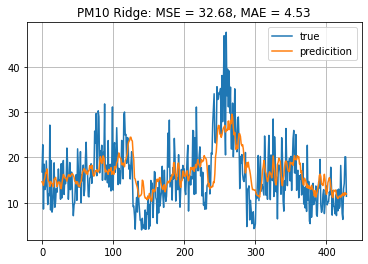

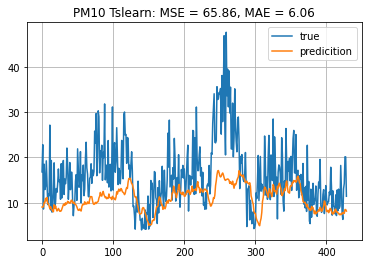

In [6]:
results_30m = []
for i in range(1, 7):
    #Fetch and prepare data
    s = '30min_' + str(i) + '.csv'
    data = pd.read_csv(s)
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    data = data.iloc[:2147-i,:]
    
    #Split data
    n = int(TRAIN_TEST_SPLIT*data.shape[0])

    X_train = data.iloc[:n,:]
    X_test = data.iloc[n:,:]

    y_train25 = X_train[labels[0]]
    y_train10 = X_train[labels[1]]

    y_true25 = X_test[labels[0]]
    y_true10 = X_test[labels[1]]

    X_train = X_train.drop(labels, axis=1)
    X_test = X_test.drop(labels, axis=1)
    
    #Define models
    xgb25 = XGBRegressor(colsample_bytree=0.5, learning_rate= 0.01, max_depth=2, n_estimators=500)
    xgb10 = XGBRegressor(colsample_bytree=0.5, learning_rate= 0.01, max_depth=3, n_estimators=500)
    
    ridge25 = Ridge(alpha=110)
    ridge10 = Ridge(alpha=150)
    
    ts25 = TimeSeriesSVR(C=1.0, kernel="gak", n_jobs=-1)
    ts10 = TimeSeriesSVR(C=1.0, kernel="gak", n_jobs=-1)
    
    #Train models
    xgb25.fit(X_train.values, y_train25)
    xgb10.fit(X_train.values, y_train10)
    
    ridge25.fit(X_train.values, y_train25)
    ridge10.fit(X_train.values, y_train10)

    ts25.fit(np.array(X_train), y_train25)
    ts10.fit(np.array(X_train), y_train25)
    
    #Perform predictions
    xgb_pred25 = xgb25.predict(X_test)
    xgb_pred10 = xgb10.predict(X_test)
    
    ridge_pred25 = ridge25.predict(X_test)
    ridge_pred10 = ridge10.predict(X_test)
    
    ts_pred25 = ts25.predict(np.array(X_test))
    ts_pred10 = ts10.predict(np.array(X_test))
    
    nn_pred25, nn_pred10, err = LSTM.lstm(data)
    
    #Results
    xgb_mse25 = mean_squared_error(y_true25, xgb_pred25)
    xgb_mae25 = mean_absolute_error(y_true25, xgb_pred25)
    
    xgb_mse10 = mean_squared_error(y_true10, xgb_pred10)
    xgb_mae10 = mean_absolute_error(y_true10, xgb_pred10)
    
    ridge_mse25 = mean_squared_error(y_true25, ridge_pred25)
    ridge_mae25 = mean_absolute_error(y_true25, ridge_pred25)
    
    ridge_mse10 = mean_squared_error(y_true10, ridge_pred10)
    ridge_mae10 = mean_absolute_error(y_true10, ridge_pred10)
    
    ts_mse25 = mean_squared_error(y_true25, ts_pred25)
    ts_mae25 = mean_absolute_error(y_true25, ts_pred25)
    
    ts_mse10 = mean_squared_error(y_true10, ts_pred10)
    ts_mae10 = mean_absolute_error(y_true10, ts_pred10)
    
    nn_mse25 = mean_squared_error(nn_pred25['y_true'], nn_pred25['y_pred'])
    nn_mae25 = mean_absolute_error(nn_pred25['y_true'], nn_pred25['y_pred'])
    
    nn_mse10 = mean_squared_error(nn_pred10['y_true1'], nn_pred10['y_pred'])
    nn_mae10 = mean_absolute_error(nn_pred10['y_true1'], nn_pred10['y_pred'])
    
    results_30m.append([xgb_mse25, xgb_mae25, xgb_mse10, xgb_mae10, ridge_mse25, ridge_mae25, 
                        ridge_mse10, ridge_mae10, ts_mse25, ts_mae25, ts_mse10, ts_mae10,
                        nn_mse25, nn_mae25, nn_mse10, nn_mae10])
    
    #Plot
    plt.plot(np.arange(len(y_true25)), y_true25, label='true')
    plt.plot(np.arange(len(xgb_pred25)), xgb_pred25, label='predicition')
    plt.title(f'PM2.5 XGBoost: MSE = {format(xgb_mse25,".2f")}, MAE = {format(xgb_mae25,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true25)), y_true25, label='true')
    plt.plot(np.arange(len(ridge_pred25)), ridge_pred25, label='predicition')
    plt.title(f'PM2.5 Ridge: MSE = {format(ridge_mse25,".2f")}, MAE = {format(ridge_mae25,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true25)), y_true25, label='true')
    plt.plot(np.arange(len(ts_pred25)), ts_pred25, label='predicition')
    plt.title(f'PM2.5 Tslearn: MSE = {format(ts_mse25,".2f")}, MAE = {format(ts_mae25,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true25)), y_true25, label='true')
    plt.plot(np.arange(len(nn_pred25['y_pred'])), nn_pred25['y_pred'], label='predicition')
    plt.title(f'PM2.5 Neural Net: MSE = {format(nn_mse25,".2f")}, MAE = {format(nn_mae25,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(np.arange(len(y_true10)), y_true10, label='true')
    plt.plot(np.arange(len(xgb_pred10)), xgb_pred10, label='predicition')
    plt.title(f'PM10 XGBoost: MSE = {format(xgb_mse10,".2f")}, MAE = {format(xgb_mae10,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true10)), y_true10, label='true')
    plt.plot(np.arange(len(ridge_pred10)), ridge_pred10, label='predicition')
    plt.title(f'PM10 Ridge: MSE = {format(ridge_mse10,".2f")}, MAE = {format(ridge_mae10,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true10)), y_true10, label='true')
    plt.plot(np.arange(len(ts_pred10)), ts_pred10, label='predicition')
    plt.title(f'PM10 Tslearn: MSE = {format(ts_mse10,".2f")}, MAE = {format(ts_mae10,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true10)), y_true10, label='true')
    plt.plot(np.arange(len(nn_pred10['y_pred'])), nn_pred10['y_pred'], label='predicition')
    plt.title(f'PM10 Neural Net: MSE = {format(nn_mse10,".2f")}, MAE = {format(nn_mae10,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    

In [7]:
header = ['XGB MSE 2.5', 'XGB MAE 2.5', 'XGB MSE 10', 'XGB MAE 10', 'Ridge MSE 2.5', 
          'Ridge MAE 2.5', 'Ridge MSE 10', 'Ridge MAE 10', 'Tslearn MSE 2.5', 'Tslearn MAE 2.5', 
          'Tslearn MSE 10', 'Tslearn MAE 10', 'LSTM MSE 2.5', 'LSTM MAE 2.5', 'LSTM MSE 10', 'LSTM MAE 10']
results_30m = pd.DataFrame(results_30m, columns=header)
results_30m.to_csv("results_30min_80.csv")

In [13]:
results_30m = pd.read_csv("results_30min.csv")
results_30m

,Unnamed: 0,XGB MSE 2.5,XGB MAE 2.5,XGB MSE 10,XGB MAE 10,Ridge MSE 2.5,Ridge MAE 2.5,Ridge MSE 10,Ridge MAE 10,Tslearn MSE 2.5,Tslearn MAE 2.5,Tslearn MSE 10,Tslearn MAE 10
0,0,8.714621,2.344323,25.298088,3.932553,8.069438,2.276089,23.441475,3.864221,10.121312,2.508534,57.606899,5.781722
1,1,9.961368,2.456437,26.778579,3.992034,9.337201,2.412557,25.068118,3.976446,11.468474,2.634027,56.950995,5.705196
2,2,11.218493,2.619891,27.654974,4.136066,10.637500,2.567290,26.689705,4.105435,13.092732,2.774385,58.273468,5.758257
3,3,12.379633,2.781315,29.872711,4.263058,11.915574,2.722851,28.480934,4.205552,13.937975,2.918210,62.463803,5.989161
4,4,13.897815,2.894713,31.342452,4.358529,13.252800,2.866670,30.756276,4.375272,15.396277,2.965254,59.650654,5.776440
5,5,16.585818,3.150222,38.037705,4.705976,14.465923,3.010350,32.679931,4.526299,17.943865,3.189711,65.856223,6.056487


In [8]:
results_1h = []
for i in range(1, 7):
    #Fetch and prepare data
    s = '1h_' + str(i) + '.csv'
    data = pd.read_csv(s)
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    data = data.iloc[:1074-i,:]
    
    #Split data
    n = int(TRAIN_TEST_SPLIT*data.shape[0])

    X_train = data.iloc[:n,:]
    X_test = data.iloc[n:,:]

    y_train25 = X_train[labels[0]]
    y_train10 = X_train[labels[1]]

    y_true25 = X_test[labels[0]]
    y_true10 = X_test[labels[1]]

    X_train = X_train.drop(labels, axis=1)
    X_test = X_test.drop(labels, axis=1)
    
    #Define models
    xgb25 = XGBRegressor(colsample_bytree=0.5, learning_rate= 0.01, max_depth=2, n_estimators=500)
    xgb10 = XGBRegressor(colsample_bytree=0.5, learning_rate= 0.01, max_depth=3, n_estimators=500)
    
    ridge25 = Ridge(alpha=110)
    ridge10 = Ridge(alpha=150)
    
    ts25 = TimeSeriesSVR(C=1.0, kernel="gak", n_jobs=-1)
    ts10 = TimeSeriesSVR(C=1.0, kernel="gak", n_jobs=-1)
    
    #Train models
    xgb25.fit(X_train.values, y_train25)
    xgb10.fit(X_train.values, y_train10)
    
    ridge25.fit(X_train.values, y_train25)
    ridge10.fit(X_train.values, y_train10)
    
    ts25.fit(X_train.values, y_train25)
    ts10.fit(X_train.values, y_train25)
    
    #Perform predictions
    xgb_pred25 = xgb25.predict(X_test)
    xgb_pred10 = xgb10.predict(X_test)
    
    ridge_pred25 = ridge25.predict(X_test)
    ridge_pred10 = ridge10.predict(X_test)
    
    ts_pred25 = ts25.predict(X_test.values)
    ts_pred10 = ts10.predict(X_test.values)
    
    nn_pred25, nn_pred10, err = LSTM.lstm(data)
    
    #Results
    xgb_mse25 = mean_squared_error(y_true25, xgb_pred25)
    xgb_mae25 = mean_absolute_error(y_true25, xgb_pred25)
    
    xgb_mse10 = mean_squared_error(y_true10, xgb_pred10)
    xgb_mae10 = mean_absolute_error(y_true10, xgb_pred10)
    
    ridge_mse25 = mean_squared_error(y_true25, ridge_pred25)
    ridge_mae25 = mean_absolute_error(y_true25, ridge_pred25)
    
    ridge_mse10 = mean_squared_error(y_true10, ridge_pred10)
    ridge_mae10 = mean_absolute_error(y_true10, ridge_pred10)
    
    ts_mse25 = mean_squared_error(y_true25, ts_pred25)
    ts_mae25 = mean_absolute_error(y_true25, ts_pred25)
    
    ts_mse10 = mean_squared_error(y_true10, ts_pred10)
    ts_mae10 = mean_absolute_error(y_true10, ts_pred10)
    
    nn_mse25 = mean_squared_error(nn_pred25['y_true'], nn_pred25['y_pred'])
    nn_mae25 = mean_absolute_error(nn_pred25['y_true'], nn_pred25['y_pred'])
    
    nn_mse10 = mean_squared_error(nn_pred10['y_true1'], nn_pred10['y_pred'])
    nn_mae10 = mean_absolute_error(nn_pred10['y_true1'], nn_pred10['y_pred'])
    
    results_1h.append([xgb_mse25, xgb_mae25, xgb_mse10, xgb_mae10, ridge_mse25, ridge_mae25, 
                       ridge_mse10, ridge_mae10, ts_mse25, ts_mae25, ts_mse10, ts_mae10,
                       nn_mse25, nn_mae25, nn_mse10, nn_mae10])
    
    #Plot
    plt.plot(np.arange(len(y_true25)), y_true25, label='true')
    plt.plot(np.arange(len(xgb_pred25)), xgb_pred25, label='predicition')
    plt.title(f'PM2.5 XGBoost: MSE = {format(xgb_mse25,".2f")}, MAE = {format(xgb_mae25,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true25)), y_true25, label='true')
    plt.plot(np.arange(len(ridge_pred25)), ridge_pred25, label='predicition')
    plt.title(f'PM2.5 Ridge: MSE = {format(ridge_mse25,".2f")}, MAE = {format(ridge_mae25,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true25)), y_true25, label='true')
    plt.plot(np.arange(len(ts_pred25)), ts_pred25, label='predicition')
    plt.title(f'PM2.5 Tslearn: MSE = {format(ts_mse25,".2f")}, MAE = {format(ts_mae25,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true25)), y_true25, label='true')
    plt.plot(np.arange(len(nn_pred25)), nn_pred25, label='predicition')
    plt.title(f'PM2.5 Neural Net: MSE = {format(nn_mse25,".2f")}, MAE = {format(nn_mae25,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true10)), y_true10, label='true')
    plt.plot(np.arange(len(xgb_pred10)), xgb_pred10, label='predicition')
    plt.title(f'PM10 XGBoost: MSE = {format(xgb_mse10,".2f")}, MAE = {format(xgb_mae10,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true10)), y_true10, label='true')
    plt.plot(np.arange(len(ridge_pred10)), ridge_pred10, label='predicition')
    plt.title(f'PM10 Ridge: MSE = {format(ridge_mse10,".2f")}, MAE = {format(ridge_mae10,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.plot(np.arange(len(y_true10)), y_true10, label='true')
    plt.plot(np.arange(len(ts_pred10)), ts_pred10, label='predicition')
    plt.title(f'PM10 Tslearn: MSE = {format(ts_mse10,".2f")}, MAE = {format(ts_mae10,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()
        
    plt.plot(np.arange(len(y_true10)), y_true10, label='true')
    plt.plot(np.arange(len(nn_pred10)), nn_pred10, label='predicition')
    plt.title(f'PM10 Neural Net: MSE = {format(nn_mse10,".2f")}, MAE = {format(nn_mae10,".2f")}')
    plt.legend()
    plt.grid()
    plt.show()

SyntaxError: invalid syntax (<ipython-input-8-1ed27625bac2>, line 75)

In [ ]:
header = ['XGB MSE 2.5', 'XGB MAE 2.5', 'XGB MSE 10', 'XGB MAE 10', 'Ridge MSE 2.5', 'Ridge MAE 2.5', 
          'Ridge MSE 10', 'Ridge MAE 10', 'Tslearn MSE 2.5', 'Tslearn MAE 2.5', 'Tslearn MSE 10', 
          'Tslearn MAE 10', 'LSTM MSE 2.5', 'LSTM MAE 2.5', 'LSTM MSE 10', 'LSTM MAE 10']
results_1h = pd.DataFrame(results_1h, columns=header)
results_1h.to_csv("results_1h.csv")

In [22]:
results_1h = pd.read_csv("results_1h.csv")
results_1h

,Unnamed: 0,XGB MSE 2.5,XGB MAE 2.5,XGB MSE 10,XGB MAE 10,Ridge MSE 2.5,Ridge MAE 2.5,Ridge MSE 10,Ridge MAE 10,Tslearn MSE 2.5,Tslearn MAE 2.5,Tslearn MSE 10,Tslearn MAE 10
0,0,5.910274,1.940337,15.530129,3.170883,5.385624,1.846933,13.330798,2.997749,8.567777,2.326217,43.995654,5.230951
1,1,8.957408,2.302048,22.334253,3.528057,8.163322,2.222720,17.120918,3.282179,10.959972,2.598293,50.820061,5.541296
2,2,12.413529,2.723033,27.659355,4.017406,10.465728,2.521488,20.676806,3.607831,13.168508,2.791997,54.528541,5.715060
3,3,14.548227,2.910534,30.286632,4.157071,12.551683,2.693205,24.320055,3.806168,14.968464,2.964026,63.044161,6.149490
4,4,15.182610,2.964466,31.169711,4.260476,14.691571,2.933433,28.378314,4.073774,17.518965,3.152152,69.409869,6.408488
5,5,16.923250,3.104194,34.159938,4.452547,16.654226,3.137978,32.213129,4.322157,21.294317,3.419831,75.590464,6.703258


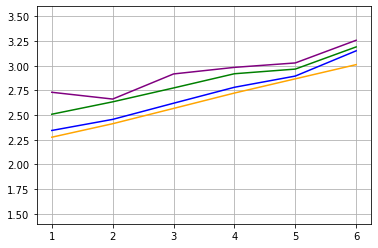

In [18]:
plt.plot(5.5, 1.5, color='white')
plt.plot(5.5, 3.5, color='white')
plt.plot(np.arange(1,7), results_30m['XGB MAE 2.5'], label='xgb', color='blue')
plt.plot(np.arange(1,7), results_30m['Ridge MAE 2.5'], label='ridge', color='orange')
plt.plot(np.arange(1,7), results_30m['Tslearn MAE 2.5'], label='tslearn', color='green')
plt.plot(np.arange(1,7), results_30m['LSTM MAE 2.5'], label='lstm', color='purple')
plt.grid()
plt.savefig('30min.png', dpi=150)
plt.show()

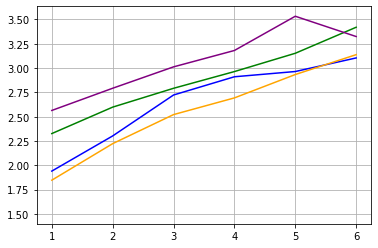

In [23]:
plt.plot(5.5, 1.5, color='white')
plt.plot(5.5, 3.5, color='white')
plt.plot(np.arange(1,7), results_1h['XGB MAE 2.5'], label='xgb', color='blue')
plt.plot(np.arange(1,7), results_1h['Ridge MAE 2.5'], label='ridge', color='orange')
plt.plot(np.arange(1,7), results_1h['Tslearn MAE 2.5'], label='tslearn', color='green')
plt.plot(np.arange(1,7), results_1h['LSTM MAE 2.5'], label='lstm', color='purple')
plt.grid()
plt.savefig('1h.png', dpi=150)
plt.show()

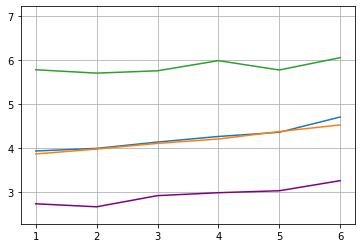

In [36]:
plt.plot(5.5, 7, color='white')
plt.plot(5.5, 2.5, color='white')
plt.plot(np.arange(1,7), results_30m['XGB MAE 10'], label='xgb')
plt.plot(np.arange(1,7), results_30m['Ridge MAE 10'], label='ridge')
plt.plot(np.arange(1,7), results_30m['Tslearn MAE 10'], label='tslearn')
plt.plot(np.arange(1,7), results_30m['LSTM MAE 2.5'], label='lstm', color='purple')
plt.grid()
plt.savefig('30m_10.png', dpi=150)
plt.show()

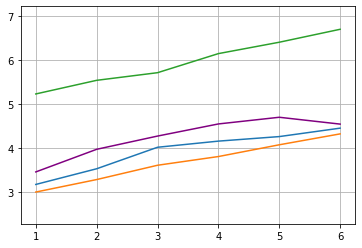

In [37]:
plt.plot(5.5, 7, color='white')
plt.plot(5.5, 2.5, color='white')
plt.plot(np.arange(1,7), results_1h['XGB MAE 10'], label='xgb')
plt.plot(np.arange(1,7), results_1h['Ridge MAE 10'], label='ridge')
plt.plot(np.arange(1,7), results_1h['Tslearn MAE 10'], label='tslearn')
plt.plot(np.arange(1,7), results_1h['LSTM MAE 10'], label='lstm', color='purple')
plt.grid()
plt.savefig('1h_10.png', dpi=150)
plt.show()

# Graphical Example

In [186]:
data = pd.read_csv('test_data/1h_1.csv')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data = data.iloc[:1074,:]

n = int(TRAIN_TEST_SPLIT*data.shape[0])

X_train = data.iloc[:n,:]
X_test = data.iloc[n:,:]

y_train25 = X_train[labels[0]]
y_train10 = X_train[labels[1]]

y_true25 = X_test[labels[0]]
y_true10 = X_test[labels[1]]

X_train = X_train.drop(labels, axis=1)
X_test = X_test.drop(labels, axis=1)

X_vis = X_test.iloc[20:40,:]
y_vis25 = y_true25[20:40]
y_vis10 = y_true10[20:40]

In [187]:
xgb25 = XGBRegressor(colsample_bytree=0.5, learning_rate= 0.01, max_depth=2, n_estimators=500)
xgb10 = XGBRegressor(colsample_bytree=0.5, learning_rate= 0.01, max_depth=3, n_estimators=500)
    
ridge25 = Ridge(alpha=110)
ridge10 = Ridge(alpha=150)
    
ts25 = TimeSeriesSVR(C=1.0, kernel="gak", n_jobs=-1)
ts10 = TimeSeriesSVR(C=1.0, kernel="gak", n_jobs=-1)

In [188]:
xgb25.fit(X_train.values, y_train25)
xgb10.fit(X_train.values, y_train10)
    
ridge25.fit(X_train.values, y_train25)
ridge10.fit(X_train.values, y_train10)
    
ts25.fit(X_train.values, y_train25)
ts10.fit(X_train.values, y_train25)

TimeSeriesSVR(n_jobs=-1)

In [189]:
X_vis = X_test.iloc[27:35,:]
y_vis25 = y_true25[27:35]
y_vis10 = y_true10[27:35]

In [190]:
xgb_pred25 = xgb25.predict(X_vis.values)
xgb_pred10 = xgb10.predict(X_vis.values)
    
ridge_pred25 = ridge25.predict(X_vis.values)
ridge_pred10 = ridge10.predict(X_vis.values)
    
ts_pred25 = ts25.predict(X_vis.values)
ts_pred10 = ts10.predict(X_vis.values)

lstm_pred25, lstm_pred10, err = LSTM.lstm(data)

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(859, 31)
(859, 1)
(859,)
(859, 1)
(859,)
(1, 1, 31)
PM2.5 input shape: (1, 1, 31)
PM10 input shape: (1, 1, 31)
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 128)               81920     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 129       
Total params: 82,049
Trainable params: 82,049
Non-trainable params: 0
_________________________________________________________________
LSTM for PM2.5 starts
Epoch 1/15
858/858 [==============================] - 2s 1ms/step - loss: 0.0196
Epoch 2/15
858/858 [==============================] - 1s 1ms/step - loss: 0.0069
Epoch 3/15
858/858 [==============================] - 1s 1ms/step - loss: 0.0071
Epoch 4/15
858/858 [==============================] - 1s 1ms/step - loss: 0.0073
Epoch 5/15
858/858 [==============================] -

In [191]:
lstm_pred25 = lstm_pred[21:29]

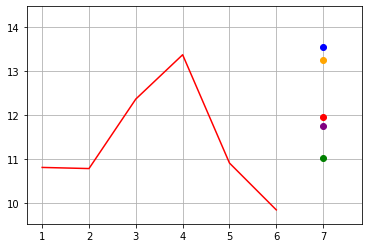

In [192]:
l = len(y_vis25) - 2
plt.plot(l+1+0.5, 14.25, marker='o', color='white')
plt.plot(l+1+0.5, 9.75, marker='o', color='white')
plt.plot(l+1, xgb_pred25[l+1], marker='o', color='blue')
plt.plot(l+1, ridge_pred25[l+1], label='ridge', marker='o', color='orange')
plt.plot(l+1, ts_pred25[l+1], label='tslearn', marker='o', color='green')

plt.plot(l+1, lstm_pred25.iloc[l+1], label='lstm', marker='o', color='purple')

plt.plot(np.arange(1,l+1), y_vis25[:l], color='red')
plt.plot(l+1, y_vis25.iloc[l+1], label='true', color='red', marker='o')
plt.grid()
plt.savefig('6.png', dpi=150)
plt.show()

# Overall performance

## PM2.5

In [209]:
lstm_pred25 = pd.read_csv("Results_pm25_lstm_raw_preliminary.csv")
lstm_25 = lstm_pred25['y_pred']

In [211]:
xgb_pred25 = xgb25.predict(X_test.values)
ridge_pred25 = ridge25.predict(X_test.values)
ts_pred25 = ts25.predict(X_test.values)

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [212]:
#Using subset for illustration
xgb_pred25 = xgb_pred25[20:100]
ridge_pred25 = ridge_pred25[20:100]
ts_pred25 = ts_pred25[20:100]
lstm_25 = lstm_25[15:95]
y_true = y_true25[20:100]

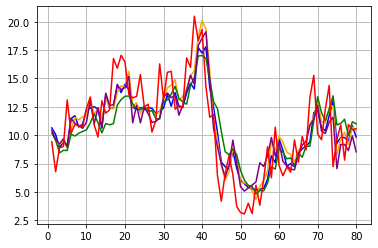

In [213]:
plt.plot(np.arange(1,len(y_true)+1), xgb_pred25, label='xgb', color='blue')
plt.plot(np.arange(1,len(y_true)+1), ridge_pred25, label='ridge', color='orange')
plt.plot(np.arange(1,len(y_true)+1), ts_pred25, label='tslearn', color='green')
plt.plot(np.arange(1,len(y_true)+1), lstm_25, label='lstm', color='purple')

plt.plot(np.arange(1,len(y_true)+1), y_true, color='red')
plt.grid()
plt.savefig('overview25.png', dpi=150)
plt.show()

In [214]:
xgb_pred25 = xgb25.predict(X_test.values)
ridge_pred25 = ridge25.predict(X_test.values)
ts_pred25 = ts25.predict(X_test.values)

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [215]:
xgb_pred25 = xgb_pred25[5:]
ridge_pred25 = ridge_pred25[5:]
ts_pred25 = ts_pred25[5:]
lstm_25 = lstm_pred25['y_pred']
y_true = y_true25[5:]

In [218]:
print(mean_absolute_error(y_true, lstm_25))
print(mean_absolute_error(y_true, xgb_pred25))
print(mean_absolute_error(y_true, ridge_pred25))
print(mean_absolute_error(y_true, ts_pred25))

1.9285037289122517
1.9334518608924458
1.8438151945528012
2.2432888610948756


## PM10 

In [219]:
lstm_pred10 = pd.read_csv("Results_pm10_lstm_raw_preliminary.csv")
lstm_10 = lstm_pred10['y_pred']

In [220]:
xgb_pred10 = xgb10.predict(X_test.values)
ridge_pred10 = ridge10.predict(X_test.values)
ts_pred10 = ts10.predict(X_test.values)

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [221]:
xgb_pred10 = xgb_pred10[20:100]
ridge_pred10 = ridge_pred10[20:100]
ts_pred10 = ts_pred10[20:100]
lstm_10 = lstm_10[15:95]

In [222]:
y_true = y_true10[20:100]

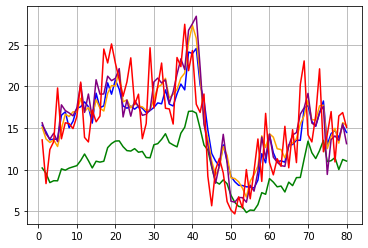

In [224]:
plt.plot(np.arange(1,len(y_true)+1), xgb_pred10, label='xgb', color='blue')
plt.plot(np.arange(1,len(y_true)+1), ridge_pred10, label='ridge', color='orange')
plt.plot(np.arange(1,len(y_true)+1), ts_pred10, label='tslearn', color='green')
plt.plot(np.arange(1,len(y_true)+1), lstm_10, label='lstm', color='purple')

plt.plot(np.arange(1,len(y_true)+1), y_true, color='red')
plt.grid()
plt.savefig('overview10.png', dpi=150)
plt.show()

In [227]:
xgb_pred10 = xgb10.predict(X_test.values)
ridge_pred10 = ridge10.predict(X_test.values)
ts_pred10 = ts10.predict(X_test.values)

/home/rwanner/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [228]:
xgb_pred10 = xgb_pred10[5:]
ridge_pred10 = ridge_pred10[5:]
ts_pred10 = ts_pred10[5:]
lstm_10 = lstm_pred10['y_pred']
y_true = y_true10[5:]

In [229]:
print(mean_absolute_error(y_true, lstm_10))
print(mean_absolute_error(y_true, xgb_pred10))
print(mean_absolute_error(y_true, ridge_pred10))
print(mean_absolute_error(y_true, ts_pred10))

3.1741785840617056
3.1743093048033053
2.986165738691842
5.470817171624779
